# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.874351,True,6.028545
1,-0.605504,False,0.250185
2,-0.244749,False,-0.991139
3,1.777477,True,6.091334
4,-0.047667,True,6.193458
...,...,...,...
995,1.549313,True,6.333093
996,0.969023,True,3.646756
997,0.367884,False,-0.688026
998,-0.397649,False,0.682808


<AxesSubplot:xlabel='v0'>

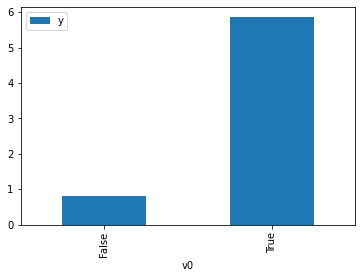

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

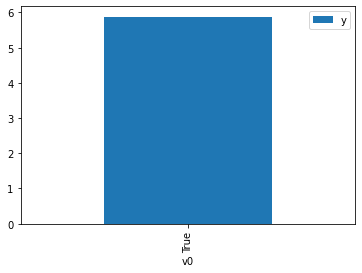

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,2.449267,False,-0.025924,0.478381,2.090386
1,0.608230,False,-0.391562,0.503896,1.984537
2,-0.693045,False,-1.415921,0.521926,1.915981
3,1.529205,False,1.897774,0.491126,2.036137
4,0.481221,False,0.702206,0.505657,1.977626
...,...,...,...,...,...
995,0.489186,False,0.136740,0.505546,1.978058
996,2.212284,False,0.353749,0.481661,2.076147
997,-1.101505,False,-1.490907,0.527576,1.895462
998,-0.139931,False,0.225691,0.514266,1.944518


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.109309,True,4.102851,0.489188,2.044206
1,0.065221,True,3.788517,0.488576,2.046762
2,0.936764,True,4.189632,0.500660,1.997364
3,1.436835,True,5.670753,0.507593,1.970081
4,0.873747,True,5.764765,0.499786,2.000857
...,...,...,...,...,...
995,0.737191,True,5.177182,0.497892,2.008466
996,3.015605,True,6.637514,0.529452,1.888745
997,0.467741,True,5.463631,0.494156,2.023651
998,1.516706,True,6.286433,0.508701,1.965792


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              8682.
Date:                Mon, 01 Aug 2022   Prob (F-statistic):                        0.00
Time:                        08:27:56   Log-Likelihood:                         -1458.2
No. Observations:                1000   AIC:                                      2920.
Df Residuals:                     998   BIC:                                      2930.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8661      0.027     32.316      0.000       0.814       0.919
x2             5.0836      0.054     94.902      0.000       4.978       5.189
==============================================================================
Omnibus:                        0.421   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.810   Jarque-Bera (JB):                0.332
Skew:                           0.036   Prob(JB):                        0.847
Kurtosis:                       3.052   Cond. No.                         2.47
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""